In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
import Ngl
import Nio 


In [2]:
import warnings
warnings.filterwarnings('ignore')


## Read in SCAM simulation (64 levels)

In [3]:
# Where the files are saved (locally):
dataDir64 = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/AllMoments-64levs/'

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.arm97.clasp_hmg_startDay'   # 32 and 64 level files *start* the same way
htg_startFile   = 'FSCAM.T42_T42.arm97.clasp_htg_startDay'
middleFile64    = '_64lev_AllMoments.cam.h0.2015-' # Default 20 min coupling
endFile         = '-00000.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months    = np.ones(31)*6
months[0] = 5
days      = np.arange(0,31)
days[0]   = 31


In [22]:
# Now read in each daily file, and save the appropriate second day to an xr dataset: 

for iDay in range(29):
    
    # Define full file names 
    hmg64file    = dataDir64+hmg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    htg64file    = dataDir64+htg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    
    # ---------------------- 
    # Read in 64 levels data
    # ----------------------
    # Read in files with homogeneous surface forcing prescribed 
    with xr.open_dataset(hmg64file, decode_times=True) as hmg64_DS:
        hmg64_DS['time']  = hmg64_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_hmg  = pd.DatetimeIndex(hmg64_DS['time'].values)
        iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
        iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            hmgDS_64 = hmg64_DS.isel(time=iTimeRange)
        else:
            hmgDS_64 = xr.concat([hmgDS_64,hmg64_DS.isel(time=iTimeRange)], dim='time')


    # Read in files with heterogeneous surface forcing prescribed     
    with xr.open_dataset(htg64file, decode_times=True) as htg64_DS:
        htg64_DS['time']  = htg64_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_htg  = pd.DatetimeIndex(htg64_DS['time'].values)
        iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
        iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            htgDS_64 = htg64_DS.isel(time=iTimeRange)
        else:
            htgDS_64 = xr.concat([htgDS_64,htg64_DS.isel(time=iTimeRange)], dim='time')
    

    print('Done with day %i' % iDay)
    

Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28


In [6]:
# Also read in the IOP files from Nate:
nateHMGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateHTGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'

nateHMG = xr.open_dataset(nateHMGfile,decode_times=True)
nateHTG = xr.open_dataset(nateHTGfile,decode_times=True)

nateTime = pd.DatetimeIndex(nateHMG.time.values, tz='UTC')



**Convert to local time**

In [7]:
# Convert times to a pandas datetime array, with UTC timezone
timesHTG_64 = pd.DatetimeIndex(htgDS_64.time.values, tz='UTC')
timesHMG_64 = pd.DatetimeIndex(hmgDS_64.time.values, tz='UTC')

# Now convert those to Central time 
timesHTG_64local = timesHTG_64.tz_convert(tz='US/Central') 
timesHMG_64local = timesHMG_64.tz_convert(tz='US/Central') 

timesNate_local = nateTime.tz_convert(tz='US/Central')

**Interpolate to constant pressure levels**

In [5]:
# New pressure levels in hPa 
pnew64 = np.arange(700.0,990.0,10.0) 

# ---------------------------------------------------
#   64 levels 
# ---------------------------------------------------
p0mb = htgDS_64.P0.values[0]/100        # mb
# Pull out hya/hyb profiles 
hyam = htgDS_64.hyam.values[0,:]
hybm = htgDS_64.hybm.values[0,:]
hyai = htgDS_64.hyai.values[0,:]
hybi = htgDS_64.hybi.values[0,:]

# Surface pressure with time dimension
PS_htg   = htgDS_64.PS.values              # Pa 
PS_hmg   = hmgDS_64.PS.values              # Pa

# Converting HTG variables: 
THLP2_htg64  = Ngl.vinth2p(htgDS_64.THLP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPTHLP_htg64 = Ngl.vinth2p(htgDS_64.WPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
UP2_htg64    = Ngl.vinth2p(htgDS_64.UP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WP2_htg64    = Ngl.vinth2p(htgDS_64.WP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WP3_htg64    = Ngl.vinth2p(htgDS_64.WP3_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPRTP_htg64  = Ngl.vinth2p(htgDS_64.WPRTP_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
RTP2_htg64   = Ngl.vinth2p(htgDS_64.RTP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPTHVP_htg64 = Ngl.vinth2p(htgDS_64.WPTHVP_CLUBB.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
WSUB_htg64   = Ngl.vinth2p(htgDS_64.WSUB.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
T_htg64      = Ngl.vinth2p(htgDS_64.T.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
Q_htg64      = Ngl.vinth2p(htgDS_64.Q.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
OMEGA_htg64  = Ngl.vinth2p(htgDS_64.OMEGA.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
THETAL_htg64 = Ngl.vinth2p(htgDS_64.THETAL.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
RVMTEND_htg64 = Ngl.vinth2p(htgDS_64.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)

# Converting HMG variables: 
THLP2_hmg64  = Ngl.vinth2p(hmgDS_64.THLP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPTHLP_hmg64 = Ngl.vinth2p(hmgDS_64.WPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
UP2_hmg64    = Ngl.vinth2p(hmgDS_64.UP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WP2_hmg64    = Ngl.vinth2p(hmgDS_64.WP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WP3_hmg64    = Ngl.vinth2p(hmgDS_64.WP3_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPRTP_hmg64  = Ngl.vinth2p(hmgDS_64.WPRTP_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
RTP2_hmg64   = Ngl.vinth2p(hmgDS_64.RTP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPTHVP_hmg64 = Ngl.vinth2p(hmgDS_64.WPTHVP_CLUBB.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
WSUB_hmg64   = Ngl.vinth2p(hmgDS_64.WSUB.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
T_hmg64      = Ngl.vinth2p(hmgDS_64.T.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
Q_hmg64      = Ngl.vinth2p(hmgDS_64.Q.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
OMEGA_hmg64  = Ngl.vinth2p(hmgDS_64.OMEGA.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
THETAL_hmg64 = Ngl.vinth2p(hmgDS_64.THETAL.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
RVMTEND_hmg64 = Ngl.vinth2p(hmgDS_64.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)


## Figure out daily rainfall amounts and how to split the data

In [39]:
# Precip saved in m/s. Ideally, let's just work in mm/day. 
#    1: Multiply by number of seconds in 20 minutes (dT) and by 1000 to convert to mm
#    2: Sum over each day (local time) 

prect_mm = htgDS_64.PRECT.values*(20.0*60.0)*1000.0

prect_daySum = np.full([len(days)-1], np.nan)  # Note: days starts on 5/31, not 6/1 (files start there), so use 1 offset

for iDay in range(len(days)-1):
    selDay = np.where(timesHTG_64local.day==days[iDay+1])[0]
    prect_daySum[iDay] = np.nansum(np.squeeze(prect_mm)[selDay])


In [241]:
#prectCutoff = np.where(prect_daySum>=0.25)[0]
prectCutoff = np.where(prect_daySum>=2)[0]

print('Num days:', len(prectCutoff))
print('Total days:', len(prect_daySum))
print(len(prectCutoff)/len(prect_daySum))

Num days: 5
Total days: 30
0.16666666666666666


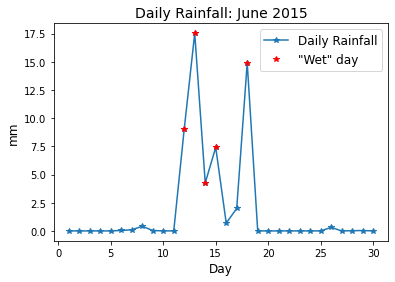

In [242]:
# Plot days that qualify based on above classification scheme 
plt.plot(days[1::],prect_daySum,'-*')
for i in range(len(prectCutoff)):
    plt.plot(days[1+prectCutoff[i]], prect_daySum[prectCutoff[i]],'r*')

plt.title('Daily Rainfall: June 2015',fontsize=14)
plt.xlabel('Day',fontsize=12)
plt.ylabel('mm',fontsize=12)
plt.legend(['Daily Rainfall','"Wet" day'], fontsize=12)


In [243]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr[1::])


In [244]:
# Define classification by day... 
time   = np.arange(1,31)
precip = prect_daySum
#wetDef = 0.25              # Based on what was used above for prectCutoff
wetDef = 2

classArr = classifyPrectDays_SCAM(time,precip,wetDef)
# Days the classification array applies to 
dayClass = pd.date_range(datetime.date(2015,6,2),date(2015,7,1)-timedelta(days=1),freq='d')



## Get diurnal cycle of interesting things, split up by day

In [245]:
'''
Function to split up an input array
into day/hour.

Inputs: Time should be a pandas datetime array. 
        Var should be a 1d array corresponding. 
Outputs: Output will be days by hours.

'''

def var_separateTime(time,var):
    
    # Get arrays of unique years/months/days/hours 
    startDay = datetime.date(time.year[0],time.month[0],time.day[0])
    var_separate = np.full([1,24], np.nan)  # Initialize array to hold daily data 
    
    # Counter for number of days to split things into
    dayCheck = 0 
    while np.isfinite(dayCheck)==True:
        iDay    = np.where((time.year==startDay.year)  & 
                           (time.month==startDay.month) &
                           (time.day==startDay.day))[0]
        
        if len(iDay)>=1:
            timeDay = time[iDay]
            varDay  = var[iDay]
            
            # Initialize array to hold hourly values
            hourlyVars = np.full([24],np.nan)
            
            for iHr in range(24):
                selHour = np.where(timeDay.hour==iHr)[0]

                # Check if not already in hourly form
                if len(selDay)>1: 
                    varHour = np.nanmean(varDay[selHour])
                elif len(selDay)<1:
                    varHour = np.nan
                else:
                    varHour = varDay[selHour]
                
                # Fill in var_separateTime by day/hour
                hourlyVars[iHr] = varHour

            # Add to a daily array 
            if dayCheck==0:
                var_separate[0,:] = hourlyVars
            else:
                #np.concatenate((var_separate, hourlyVars[:,None]),axis=0)
                var_separate = np.append(var_separate, np.reshape(hourlyVars,[1,24]), axis=0)
            
            # Set next day 
            startDay = startDay+datetime.timedelta(days=1)
            dayCheck = dayCheck+1
        else: 
            dayCheck = np.nan
    
    return(var_separate)

In [246]:
# Split up PBLH into day/hourly mean arrays 
PBLH_hmgDaily = var_separateTime(timesHTG_64local,hmgDS_64.PBLH.values)
PBLH_htgDaily = var_separateTime(timesHTG_64local,htgDS_64.PBLH.values)

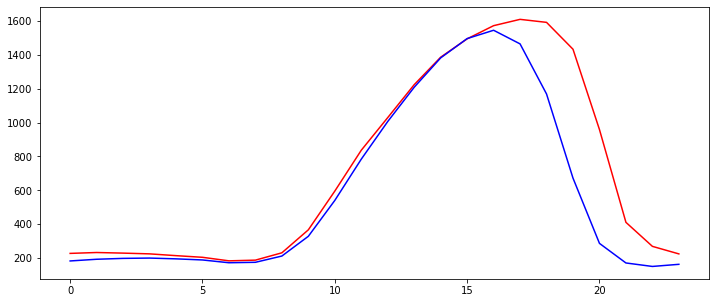

In [201]:
# Sanity check that I'm still seeing the same thing as before -- yep! 
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.arange(0,24), np.nanmean(PBLH_hmgDaily,axis=0),'r')
ax1.plot(np.arange(0,24), np.nanmean(PBLH_htgDaily,axis=0), 'b')

### Plot up PBLH differences on wW,wD,dW,dD days 

Text(1, 1300, '22 Days of dD')

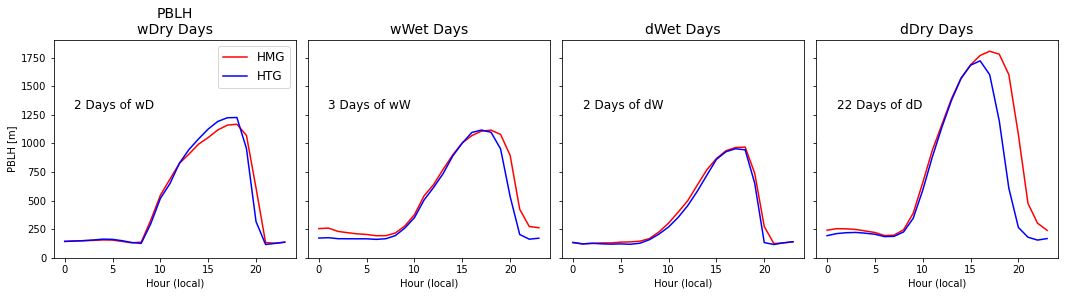

In [247]:
# Pad classArr so that first element is present, but empty
classArr_pad = np.insert(classArr, 0, 'None')

iwW = np.where(classArr_pad=='wWet')[0]
iwD = np.where(classArr_pad=='wDry')[0]
idW = np.where(classArr_pad=='dWet')[0]
idD = np.where(classArr_pad=='dDry')[0]

#  Set up figure
# ----------------
fig, axs_all = plt.subplots(1,4, figsize=(18, 4),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.35)


axs[0].plot(np.arange(0,24), np.nanmean(PBLH_hmgDaily[iwD,:],axis=0),'r')
axs[0].plot(np.arange(0,24), np.nanmean(PBLH_htgDaily[iwD,:],axis=0), 'b')
axs[0].set_title('PBLH\nwDry Days',fontsize=14)
axs[0].legend(['HMG','HTG'],fontsize=12)

axs[1].plot(np.arange(0,24), np.nanmean(PBLH_hmgDaily[iwW,:],axis=0),'r')
axs[1].plot(np.arange(0,24), np.nanmean(PBLH_htgDaily[iwW,:],axis=0), 'b')
axs[1].set_title('wWet Days',fontsize=14)

axs[2].plot(np.arange(0,24), np.nanmean(PBLH_hmgDaily[idW,:],axis=0),'r')
axs[2].plot(np.arange(0,24), np.nanmean(PBLH_htgDaily[idW,:],axis=0), 'b')
axs[2].set_title('dWet Days',fontsize=14)

axs[3].plot(np.arange(0,24), np.nanmean(PBLH_hmgDaily[idD,:],axis=0),'r')
axs[3].plot(np.arange(0,24), np.nanmean(PBLH_htgDaily[idD,:],axis=0), 'b')
axs[3].set_title('dDry Days',fontsize=14)

# Fix ylim to be constant
axs[0].set_ylim([0,1900])
axs[1].set_ylim([0,1900])
axs[2].set_ylim([0,1900])
axs[3].set_ylim([0,1900])

# Remove y-ticks for all but first plot, shrink space between them 
axs[1].tick_params(labelleft=False) 
axs[2].tick_params(labelleft=False) 
axs[3].tick_params(labelleft=False) 
fig.subplots_adjust(wspace=0.05)

# Add axis labels
axs[0].set_ylabel('PBLH [m]')
axs[0].set_xlabel('Hour (local)')
axs[1].set_xlabel('Hour (local)')
axs[2].set_xlabel('Hour (local)')
axs[3].set_xlabel('Hour (local)')

# Add number of days going into average 
axs[0].text(1,1300,str(len(iwD))+' Days of wD',fontsize=12)
axs[1].text(1,1300,str(len(iwW))+' Days of wW',fontsize=12)
axs[2].text(1,1300,str(len(idW))+' Days of dW',fontsize=12)
axs[3].text(1,1300,str(len(idD))+' Days of dD',fontsize=12)
